**TESTING ENV RENDER AND IMAGE**

In [2]:
import gymnasium as gym
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import numpy as np
import base64
from PIL import Image
import io
import os
from openai import OpenAI
from openaikey import OPENAI_API_KEY
import custom_parking


def env_render_to_base64(env):
    env.reset()
    rendered = env.render()
    # Convert numpy array to PIL Image
    image = Image.fromarray(rendered)

    # Save the image to a BytesIO object
    buffer = io.BytesIO()
    image.save(buffer, format='JPEG')

    # Get the content of the BytesIO object
    image_bytes = buffer.getvalue()

    # Encode the bytes to base64
    image_base64 = base64.b64encode(image_bytes)

    # If you need it as a string
    image_base64_str = image_base64.decode('utf-8')
    return image_base64_str

def prompt_api_vision(openai_client, prompt, image64) -> str:
    response = openai_client.chat.completions.create(
    model="gpt-4-turbo",
    messages = [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": prompt,
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{image64}",
                "detail": "low"
            },
            },
        ],
        }
    ],
    max_tokens=500,
    )
    return response.choices[0].message.content

def prompt_api_no_vision(openai_client, prompt1) -> str:
    response = openai_client.chat.completions.create(
    model="gpt-4-turbo",
    messages = [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": prompt1,
            },
        ],
        }
    ],
    max_tokens=500,
    )
    return response.choices[0].message.content



/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


In [3]:
import os
from openai import OpenAI
from openaikey import OPENAI_API_KEY


client = OpenAI(api_key=OPENAI_API_KEY)


def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict = None, p: float = 0.5) -> float:
        """
        Proximity to the goal is rewarded

        We use a weighted p-norm

        :param achieved_goal: the goal that was achieved
        :param desired_goal: the goal that was desired
        :param dict info: any supplementary information
        :param p: the Lp^p norm used in the reward. Use p<1 to have high kurtosis for rewards in [0, 1]
        :return: the corresponding reward
        """
        return -np.power(np.dot(np.abs(achieved_goal - desired_goal), np.array(self.config["reward_weights"])), p)

env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
env.reset()

image_base64_str = env_render_to_base64(env)

env_description = """
Here is an image of a top-down view of a parking lot. 
The parking area is surrounded by a yellow border.
The parking lot has numerous empty parking spots marked by white lines on a gray surface. 
There is a green car which can be controlled via throttle and steering angle. 
There is a blue object which represents the goal parking spot where we would like the car to end up within the neighboring white lines. 
Our observations come in the form of a tuple of:
OrderedDict([
             ('observation', array([ 0., 0. ,0., -0.,  0.65025885, -0.75971273])), 
             ('achieved_goal', array([ 0.,  0.,  0., -0.,  0.65025885, -0.75971273])),
             ('desired_goal', array([2.200000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00, 6.123234e-17, 1.000000e+00]))
            ]),
Where each array corresponds to the following: ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'] of the car.
Please describe 5 behavoirs in natural language that would incentivize an agent to efficiently learn how to park the car on the blue spot at the right angle.
"""

language_to_code_prompt = """
You are an assistant tasked with turning language subgoals into machine readable code. You will be given a list of text subgoals/desired behaviors, and you must translate these subgoals into code that takes in an observation of the format:
OrderedDict([
             ('observation', array([ 0., 0. ,0., -0.,  0.65025885, -0.75971273])), 
             ('achieved_goal', array([ 0.,  0.,  0., -0.,  0.65025885, -0.75971273])),
             ('desired_goal', array([2.200000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00, 6.123234e-17, 1.000000e+00]))
            ])
Where each array corresponds to the following: ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'] of the car's current state and desired state.
Feel free to use if statements, loops, or any other python code to achieve all 5 behaviors.
Please respond with only the code for the reward function which is defined by def compute_reward(achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict, p: float = 0.5) -> float:
The reward function should address each point in the following list:
""" 


natural_language = language_to_code_prompt + prompt_api_vision(client, env_description, image_base64_str)
print(natural_language)
code = prompt_api_no_vision(client, language_to_code_prompt)
print(code)



You are an assistant tasked with turning language subgoals into machine readable code. You will be given a list of text subgoals/desired behaviors, and you must translate these subgoals into code that takes in an observation of the format:
OrderedDict([
             ('observation', array([ 0., 0. ,0., -0.,  0.65025885, -0.75971273])), 
             ('achieved_goal', array([ 0.,  0.,  0., -0.,  0.65025885, -0.75971273])),
             ('desired_goal', array([2.200000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00, 6.123234e-17, 1.000000e+00]))
            ])
Where each array corresponds to the following: ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'] of the car's current state and desired state.
Feel free to use if statements, loops, or any other python code to achieve all 5 behaviors.
Please respond with only the code for the reward function which is defined by def compute_reward(achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict, p: float = 0.5) -> float:
The reward function sh

In [17]:
# code2 = "\n".join(code.splitlines()[1:-1])
from stable_baselines3.common.logger import configure

def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict, p: float = 0.5) -> float:
    # Extract position and heading data
    ax, ay, avx, avy, acos_h, asin_h = achieved_goal
    dx, dy, dvx, dvy, dcos_h, dsin_h = desired_goal
    
    # Calculate distance to the goal position
    position_error = np.sqrt((ax - dx) ** 2 + (ay - dy) ** 2)
    
    # Calculate heading error using the dot product for angular similarity
    heading_error = 1 - (np.dot([acos_h, asin_h], [dcos_h, dsin_h]) / 
                        (np.linalg.norm([acos_h, asin_h]) * np.linalg.norm([dcos_h, dsin_h])))
    
    # Calculate speed error (ideally the speed should be zero at parking)
    speed_error = np.sqrt(avx**2 + avy**2)

    # Weight for the speed error increases as the car gets closer to the goal
    # This could be a simple inverse function of the position error or a more complex function as needed
    speed_weight = 1 / (position_error + 0.1)  # adding 0.1 to avoid division by zero

    # Define reward components
    # Higher weight on position and heading errors
    reward_position = -position_error
    reward_heading = -heading_error * 5  # emphasizing correct orientation
    reward_speed = -speed_weight * speed_error  # dynamic weighting of speed error
    
    # Time or step penalty to encourage efficiency (info dictionary holds the step count)
    step_penalty = -0.1 * info.get('step', 0)  # 0.1 penalty per step
    
    # Combine the rewards with penalties
    total_reward = (p * (reward_position + reward_heading) + (1 - p) * reward_speed) + step_penalty
    
    return total_reward

env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
print(env.action_space)

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

tmp_path = "wiley/log"
# set up logger
new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])

model = DDPG("MultiInputPolicy", env, verbose=1)
model.set_logger(new_logger)
# model = DDPG.load("ddpg_parking_ai_reward", env = env, action_noise=action_noise)
model.learn(total_timesteps=10000)
model.save("ddpg_parking_ai_reward")

vec_env = model.get_env()
obs = vec_env.reset()
for i in range(100):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    vec_env.render("human")


Box(-1.0, 1.0, (2,), float32)
Logging to wiley/log
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 58.5     |
|    ep_rew_mean     | -223     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 90       |
|    time_elapsed    | 2        |
|    total_timesteps | 234      |
| train/             |          |
|    actor_loss      | 5.07     |
|    critic_loss     | 0.263    |
|    learning_rate   | 0.001    |
|    n_updates       | 133      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 106      |
|    ep_rew_mean     | -212     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 67       |
|    time_elapsed    | 12       |
|    

    train/critic_loss  time/time_elapsed  time/total_timesteps  \
0            0.263453                  2                   234   
1            0.629991                 12                   845   
2            0.182027                 25                  1665   
3            1.424029                 30                  1930   
4            0.528482                 41                  2582   
5            0.579538                 51                  3148   
6            0.542714                 61                  3799   
7            0.848313                 65                  4043   
8            0.374567                 77                  4658   
9            0.387832                101                  6178   
10           0.131368                121                  7360   
11           0.259573                147                  8878   
12           0.280130                150                  9050   
13           0.297730                155                  9312   
14        

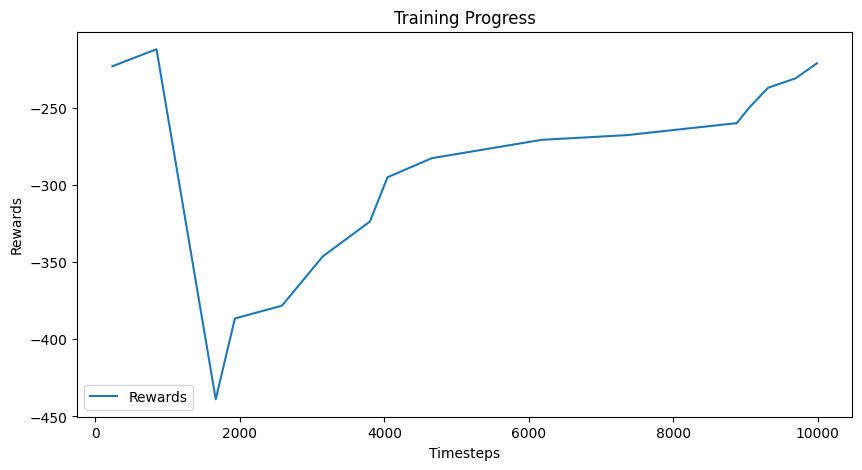

: 

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/ep_rew_mean'], label='Rewards')
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.title('Training Progress')
plt.legend()
plt.show()


In [7]:
def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict, p: float = 0.5) -> float:
    # Extract position and heading data
    ax, ay, avx, avy, acos_h, asin_h = achieved_goal
    dx, dy, dvx, dvy, dcos_h, dsin_h = desired_goal
    
    # Calculate distance to the goal position
    position_error = np.sqrt((ax - dx) ** 2 + (ay - dy) ** 2)
    
    # Calculate heading error using the dot product for angular similarity
    heading_error = 1 - (np.dot([acos_h, asin_h], [dcos_h, dsin_h]) / 
                        (np.linalg.norm([acos_h, asin_h]) * np.linalg.norm([dcos_h, dsin_h])))
    
    # Calculate speed error (ideally the speed should be zero at parking)
    speed_error = np.sqrt(avx**2 + avy**2)

    # Weight for the speed error increases as the car gets closer to the goal
    # This could be a simple inverse function of the position error or a more complex function as needed
    speed_weight = 1 / (position_error + 0.1)  # adding 0.1 to avoid division by zero

    # Define reward components
    # Higher weight on position and heading errors
    reward_position = -position_error
    reward_heading = -heading_error * 5  # emphasizing correct orientation
    reward_speed = -speed_weight * speed_error  # dynamic weighting of speed error
    
    # Time or step penalty to encourage efficiency (info dictionary holds the step count)
    step_penalty = -0.1 * info.get('step', 0)  # 0.1 penalty per step
    
    # Combine the rewards with penalties
    total_reward = (p * (reward_position + reward_heading) + (1 - p) * reward_speed) + step_penalty
    
    return total_reward

env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
model = DDPG.load("ddpg_parking_ai_reward", env=env)


vec_env = model.get_env()
obs = vec_env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    vec_env.render("human")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
